# Load dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

# Import training data and check out info

In [2]:
train = pd.read_csv('../data/train.csv')
train.set_index(train['Id'])
train.drop('Id', axis=1, inplace=True)
train.select_dtypes(exclude='object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   LotFrontage    1201 non-null   float64
 2   LotArea        1460 non-null   int64  
 3   OverallQual    1460 non-null   int64  
 4   OverallCond    1460 non-null   int64  
 5   YearBuilt      1460 non-null   int64  
 6   YearRemodAdd   1460 non-null   int64  
 7   MasVnrArea     1452 non-null   float64
 8   BsmtFinSF1     1460 non-null   int64  
 9   BsmtFinSF2     1460 non-null   int64  
 10  BsmtUnfSF      1460 non-null   int64  
 11  TotalBsmtSF    1460 non-null   int64  
 12  1stFlrSF       1460 non-null   int64  
 13  2ndFlrSF       1460 non-null   int64  
 14  LowQualFinSF   1460 non-null   int64  
 15  GrLivArea      1460 non-null   int64  
 16  BsmtFullBath   1460 non-null   int64  
 17  BsmtHalfBath   1460 non-null   int64  
 18  FullBath

# Exploratory Data Analysis

- Create Total SF.
- Plot scatterplots of main features: Total SF, TotRmsAbvGrd, YearBuilt, LotArea, OverallQual
- Remove outliers.
- Check for highly skewed features.

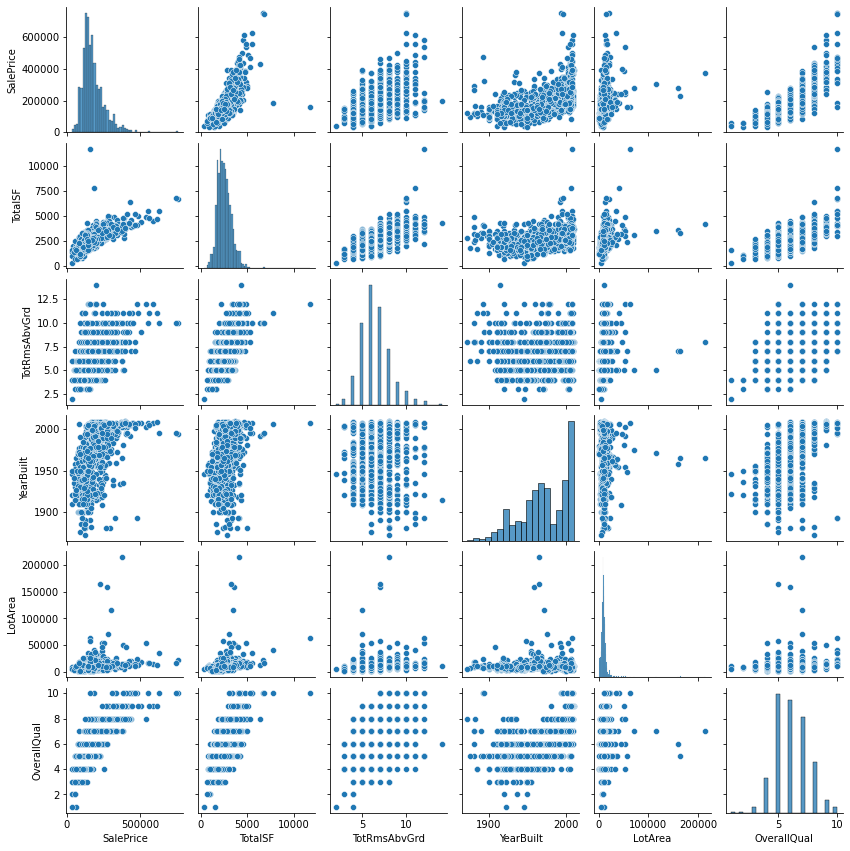

In [3]:
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
sns.pairplot(data=train[['SalePrice',
                         'TotalSF',
                         'TotRmsAbvGrd',
                         'YearBuilt',
                         'LotArea',
                         'OverallQual']], height=2)

In [4]:
# Drop outliers
train.drop(train.index[train.TotalSF>7500],axis=0, inplace=True)
train.drop(train.index[train.LotArea>10e4],axis=0, inplace=True)

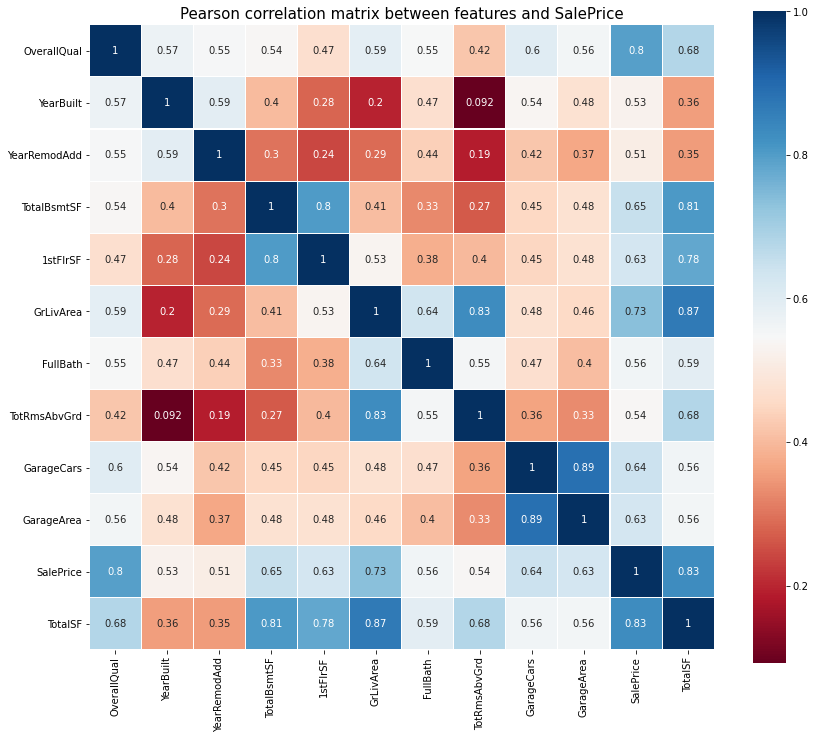

In [5]:
corr_train = train.corr()
highest_corr_features = corr_train.index[abs(corr_train['SalePrice']) > 0.5]

plt.figure(figsize=(14,12))
plt.title('Pearson correlation matrix between features and SalePrice', y=1, size=15)
sns.heatmap(train[highest_corr_features].corr(),
            linewidths=0.1,
            vmax=1.0, 
            square=True,
            cmap='RdBu',
            linecolor='white',
            annot=True)
plt.show()

# Feature Engineering

Impute missing values
- Numerical features: use sample median
- Ordinal features: use sample mode
- Non-ordinal categorical features: use sample mode

Encode categorical values
- Ordinal features: use ordinal encoder
- Non-ordinal categorical features: use target encoding

In [6]:
cols_missing_value = train.columns[train.isna().sum()>0].values
cols_missing_value
train[cols_missing_value].info()

'''
Impute missing numerical features using median
'''
missing_num_att = train[cols_missing_value].select_dtypes(exclude='object').columns
for att in missing_num_att:
    train[att].fillna(train[att].median(), inplace=True)
    
'''
Impute missing categorical/ordinal features using mode
'''  
missing_cat_att = train[cols_missing_value].select_dtypes(include='object').columns
for att in missing_cat_att:
    train[att].fillna(train[att].mode()[0], inplace=True)
    
train[cols_missing_value].isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1454 entries, 0 to 1459
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1198 non-null   float64
 1   Alley         91 non-null     object 
 2   MasVnrType    1446 non-null   object 
 3   MasVnrArea    1446 non-null   float64
 4   BsmtQual      1417 non-null   object 
 5   BsmtCond      1417 non-null   object 
 6   BsmtExposure  1416 non-null   object 
 7   BsmtFinType1  1417 non-null   object 
 8   BsmtFinType2  1416 non-null   object 
 9   Electrical    1453 non-null   object 
 10  FireplaceQu   764 non-null    object 
 11  GarageType    1373 non-null   object 
 12  GarageYrBlt   1373 non-null   float64
 13  GarageFinish  1373 non-null   object 
 14  GarageQual    1373 non-null   object 
 15  GarageCond    1373 non-null   object 
 16  PoolQC        6 non-null      object 
 17  Fence         281 non-null    object 
 18  MiscFeature   52 non-null   

LotFrontage     0
Alley           0
MasVnrType      0
MasVnrArea      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
FireplaceQu     0
GarageType      0
GarageYrBlt     0
GarageFinish    0
GarageQual      0
GarageCond      0
PoolQC          0
Fence           0
MiscFeature     0
dtype: int64

In [7]:
num_att = ['LotFrontage','LotArea','OverallQual',
           'OverallCond','YearBuilt','YearRemodAdd',
           'MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
           'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF',
           'GrLivArea','BsmtFullBath','BsmtHalfBath',
           'FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
           'TotRmsAbvGrd','Fireplaces','GarageYrBlt',
           'GarageCars','GarageArea','WoodDeckSF','OpenPorchSF',
           'EnclosedPorch','3SsnPorch','ScreenPorch',
           'PoolArea','MiscVal','MoSold','YrSold']

ordinal_att = ['LotShape', 'Utilities', 'LandSlope',
               'ExterQual','ExterCond','BsmtQual',
               'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
               'BsmtFinType2', 'HeatingQC','CentralAir',
               'KitchenQual','Functional','FireplaceQu',
               'GarageFinish', 'GarageQual', 'GarageCond',
               'PavedDrive','PoolQC','Fence']

cat_att = ['MSZoning','Street','Alley',
           'LandContour','LotConfig','Neighborhood',
           'BldgType','HouseStyle','RoofStyle',
           'RoofMatl','MasVnrType','Foundation',
           'Heating','Electrical','GarageType',
           'MiscFeature','SaleType','SaleCondition',
           'Condition1','Condition2','Exterior1st','Exterior2nd']

In [8]:
from sklearn.preprocessing import OrdinalEncoder
OrdinalEncoder = OrdinalEncoder()

def cat_encoder(df, att):
    '''
    Target encoding:
    replace categorical values with mean 
    sale price by category
    '''
    impute_dict = df.groupby(att).agg({'SalePrice':'mean'}).to_dict()
    df[att] = df[att].map(impute_dict['SalePrice'])
    return df[att]

def data_prep(df, num_att, ordinal_att, cat_att):
    
    '''
    numerical att:
    return numerical columns
    '''
    numerical_data = df[num_att].to_numpy()
    
    '''
    ordinal encoder:
    return ordinal columns
    '''
    # Quality/condition features
    QC = ['ExterQual', 'ExterCond',
          'BsmtQual', 'BsmtCond', 
          'HeatingQC', 
          'KitchenQual',
          'FireplaceQu', 
          'GarageQual', 'GarageCond',
          'PoolQC']
    QC_dict = {'Po':1, 'Fa': 2, 'TA':3, 'Gd':4, 'Ex':5}
    train[QC] = train[QC].replace(QC_dict)
    
    # BsmtFinType
    BsmtFinType = ['BsmtFinType1', 'BsmtFinType2']
    BsmtFinType_dict = {'Unf':1, 'LwQ': 2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ': 6}
    train[BsmtFinType] = train[BsmtFinType].replace(BsmtFinType_dict)
    
    # BsmtExposure
    BsmtExposure_dict = {'No':1, 'Mn':2, 'Av':3, 'Gd': 4}
    train['BsmtExposure'] = train['BsmtExposure'].replace(BsmtExposure_dict)

    # CentralAir
    CentralAir_dict = {'N':1, 'Y':2}
    train['CentralAir'] = train['CentralAir'].replace(CentralAir_dict)
    
    # Fence
    Fence_dict = {'NA':1,'MnWw':2, 'GdWo':3, 'MnPrv':4,  'GdPrv':5}
    train['Fence'] = train['Fence'].replace(Fence_dict)
    
    # Functional
    Functional_dict = {'Sal':1, 'Sev':1, 'Maj1': 2, 'Maj2':2, 'Mod':3, 'Min1':4, "Min2": 4, "Typ": 5}
    train['Functional'] = train['Functional'].replace(Functional_dict)
    
    # GarageFinish
    GarageFinish_dict = {'Unf':1,'RFn': 2, 'Fin':3}
    train['GarageFinish'] = train['GarageFinish'].replace(GarageFinish_dict)
    
    # LandSlope
    LandSlope_dict = {'Sev':1, 'Mod':2, 'Gtl':3}
    train['LandSlope'] = train['LandSlope'].replace(LandSlope_dict)
    
    # LotShape
    LotShape_dict = {'IR3': 1, 'IR2':2, 'IR1':3, 'Reg':4}
    train['LotShape'] = train['LotShape'].replace(LotShape_dict)
    
    # PavedDrive
    PavedDrive_dict = {'N':1, 'P':2, 'Y': 3}
    train['PavedDrive'] = train['PavedDrive'].replace(PavedDrive_dict)

    # Utilities
    Utilities_dict = {'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4}
    train['Utilities'] = train['Utilities'].replace(Utilities_dict)
    ordinal_data = OrdinalEncoder.fit_transform(train[ordinal_att])
    
    '''
    non-ordinal categorical encoder:
    return cateogrical columns
    '''
    for att in cat_att:
        cat_encoder(df, att)
    categorical_data = df[cat_att].to_numpy().copy()
    
    train_cleaned = np.concatenate([numerical_data, 
                                    ordinal_data, 
                                    categorical_data], axis=1)
    return train_cleaned, np.log(train['SalePrice'].values)
    
X_train_prep, y_train = data_prep(train, num_att, ordinal_att, cat_att)

# Model

The goal is to find a model that minimizes RMSE, where the target is "SalePrice." I will be experimenting with the following models:
- Random Forests Regression
- Gradient Boosting Regression
- Light Gardient Boosting Machine (LGBM) Regression
- Extreme Gradient Boosting (XGB) Regression
- a Stacked Meta-Learner

##### Step 1.
Create helper functions that evaluate the RMSE score and perform K-fold cross-validation on the training dataset to avoid overfitting.

##### Step 2.
Test the different models and save the best model parameters.

##### Step 3.
Build a stacked regressor combining the base models and a linear regression meta learner.

# RMSE Helper Functions

In [9]:
# RMSE scorer
def get_rmse(y_test, y_predict):
    rmse = np.sqrt(mean_squared_error(y_test, y_predict))
    return rmse

# Initialize RMSE scorer
rmse_scorer = make_scorer(get_rmse, greater_is_better=False)

# K-Fold cross-validation RMSE
rng = np.random.RandomState(17)
kfolds = KFold(n_splits=5, shuffle=True, random_state=rng)
def cv_rmse(model, X, y):
    cv_rmse = -cross_val_score(model, X, y, scoring=rmse_scorer, cv=kfolds)
    return cv_rmse

# Random Forest

In [10]:
# Random Forest Regressor function
def RFR_fn(params):
    
    params = {'n_estimators' : int(params['n_estimators']),
              'max_depth' : int(params['max_depth']),
              'min_samples_leaf' : int(params['min_samples_leaf']),
              'max_features' : int(params['max_features']),}
    
    model = RandomForestRegressor(random_state=rng, **params)
    
    score = np.mean(cv_rmse(model, X_train_prep, y_train))

    return score

In [ ]:
# Hyperparameter space
space = {'n_estimators' : hp.quniform('n_estimators', low=1000, high=5000, q=250),
         'min_samples_leaf' : hp.quniform('min_samples_leaf', low=1, high=8, q=1),
         'max_depth' : hp.quniform('max_depth', low=2, high=8, q=1),
         'max_features' : hp.quniform('max_features', low=2, high=20, q=2),}

# Hyperparameter tuning
trials = Trials()
RFR_best_params = fmin(fn=RFR_fn, 
                       space=space, 
                       algo=tpe.suggest, 
                       max_evals=25*5, 
                       trials=trials, 
                       rstate=rng)
pickle.dump(RFR_best_params, open("../output/RFR.pkl", "wb"))

  0%|          | 0/125 [00:00<?, ?trial/s, best loss=?]

In [ ]:
# Final score
RFR_best_params = pickle.load(open("../output/RFR.pkl", "rb"))
RFR_fn(RFR_best_params)

# Gradient Boosting Regressor

In [ ]:
# Gradient Boosting Regressor function
def GBR_fn(params):
    
    params = {'n_estimators' : int(params['n_estimators']),
              'learning_rate' : params['learning_rate'],
              'max_depth' : int(params['max_depth']),
              'min_samples_leaf' : int(params['min_samples_leaf']),
              'max_features' : int(params['max_features']),}
    
    model = GradientBoostingRegressor(random_state=rng, loss='huber', **params)
    
    score = np.mean(cv_rmse(model, X_train_prep, y_train))

    return score

In [ ]:
# Hyperparameter space
space = {'n_estimators' : hp.quniform('n_estimators', low=1000, high=5000, q=250),
         'learning_rate' : hp.uniform('learning_rate', low=0.005, high=0.1),
         'min_samples_leaf' : hp.quniform('min_samples_leaf', low=1, high=8, q=1),
         'max_depth' : hp.quniform('max_depth', low=2, high=8, q=1),
         'max_features' : hp.quniform('max_features', low=2, high=20, q=2),}

trials = Trials()
GBR_best_params = fmin(fn=GBR_fn, space=space, algo=tpe.suggest, max_evals=25*5, trials=trials, rstate=rng)
pickle.dump(GBR_best_params, open("../output/GBR.pkl", "wb"))

In [ ]:
# Final score
GRB_best_params = pickle.load(open("../output/GBR.pkl", "rb"))
GBR_fn(GRB_best_params)

# LightGBM

In [ ]:
# Light Gradient Boosted Machine function
def LGBM_fn(params):
    
    params = {'n_estimators' : int(params['n_estimators']),
              'learning_rate' : params['learning_rate'],
              'max_depth' : int(params['max_depth']),
              'min_child_samples' : int(params['min_child_samples']),
              'num_leaves' : int(params['num_leaves']),
              'max_bin' : int(params['max_bin']),
              'subsample_freq' : int(params['subsample_freq']),
              'subsample' : params['subsample'],
              'reg_alpha' : params['reg_alpha'],
              'reg_lambda' : params['reg_lambda'],
             }
    
    model = LGBMRegressor(random_state=rng, **params)
    
    score = np.mean(cv_rmse(model, X_train_prep, y_train))

    return score

In [ ]:
# Hyperparameter space
space = {'n_estimators' : hp.quniform('n_estimators', low=1000, high=5000, q=250),
         'learning_rate' : hp.uniform('learning_rate', low=0.005, high=0.1),
         'max_depth': hp.quniform('max_depth', low=2, high=8, q=1),
         'min_child_samples' : hp.quniform('min_child_samples', low=2, high=10, q=1),
         'num_leaves' : hp.quniform('num_leaves', low=6, high=20, q=2),
         'max_bin' : hp.quniform('max_bin', low=100, high=300, q=20),
         'subsample_freq' : hp.quniform('subsample_freq', low=5, high=10, q=1),
         'subsample' : hp.uniform('subsample', low=0.5, high=1),
         'reg_alpha' : hp.uniform('reg_alpha', low=0, high=0.5),
         'reg_lambda' : hp.uniform('reg_lambda', low=0.5, high=1),}

# Hyperparameter tuning
trials = Trials()
LGBM_best_params = fmin(fn=LGBM_fn, space=space, algo=tpe.suggest, max_evals=25*5, trials=trials, rstate=rng)
pickle.dump(LGBM_best_params, open("../output/LGBM.pkl", "wb"))

In [ ]:
LGBM_best_params = pickle.load(open("../output/LGBM.pkl", "rb"))
LGBM_fn(LGBM_best_params)

# XGB Rgressor

In [ ]:
# Extreme Gradient Boosting function
def XGBR_fn(params):
    
    params = {'n_estimators' : int(params['n_estimators']),
              'max_depth' : int(params['max_depth']),
              'learning_rate' : params['learning_rate'],
              'min_child_weight':int(params['min_child_weight']),
              'subsample':params['subsample'],
              'colsample_bytree':params['colsample_bytree'],
              'reg_alpha':params['reg_alpha'],
              'reg_lambda':params['reg_lambda'],}
    
    model = XGBRegressor(random_state=rng, **params)
    
    score = np.mean(cv_rmse(model, X_train_prep, y_train))

    return score

In [ ]:
# Hyperparameter space
space = {'n_estimators' : hp.quniform('n_estimators', low=1000, high=5000, q=250),
         'max_depth' : hp.quniform('max_depth', low=2, high=8, q=1),
         'learning_rate': hp.uniform('learning_rate', low=0.05, high=0.1),
         'min_child_weight':hp.quniform('min_child_weight', low=0, high=6, q=1),
         'subsample':hp.uniform('subsample', low=0.2, high=0.8),
         'colsample_bytree':hp.uniform('colsample_bytree', low=0.05, high=0.5),
         'reg_alpha':hp.uniform('reg_alpha', low=0, high=0.5),
         'reg_lambda':hp.uniform('reg_lambda', low=0.5, high=1),}

# Hyperparameter tuning
trials = Trials()
XGBR_best_params = fmin(fn=XGBR_fn, space=space, algo=tpe.suggest, max_evals=25*5, trials=trials, rstate=rng)
pickle.dump(XGBR_best_params, open("../output/XGBR.pkl", "wb"))

In [ ]:
XGBR_best_params = pickle.load(open("../output/XGBR.pkl", "rb"))
XGBR_fn(XGBR_best_params)

# Stacked Regressor